#Solid Waste(Trash) Generation Classification using Deep Learning

Sustainable solid waste management is essential. This implies waste reduction, reuse, recycling and composting, incineration, and disposal in landfills. Waste reduction, recycling, reuse and composting are preferred methods and should be promoted, as they reduce demand on scarce environmental resources, decrease energy use, and minimize the quantity of waste that must eventually be incinerated or disposed of in landfills.

This is of classifying Solid waste generation 

#Objective

computer vision makes a classification model of waste generation based on photos of glass, paper, cardboard, plastic, plasticbags,  metal, and trash. A convolutional neural network framework is used classify photos of waste generation.

#Key Concepts:

##Habana® Gaudi® processor
The Habana® Gaudi® processor is designed to maximize training throughput and efficiency, while providing developers with optimized software and tools that scale to many workloads and systems. Habana Gaudi software was developed with the end-user in mind, providing versatility and ease of programming to address the unique needs of users’ proprietary models, while allowing for a simple and seamless transition of their existing models over to Gaudi.

##Data Augmentation
Data Augmentation is a practice that is commonly used in image classification that enlarges the existing image dataset by creating new data sets from the existing data. This augmentation is most commonly seen in operations like shifting the image, mirroring the image horizontally or vertically, zooming in on the image, and so on. These augmentations then create new images and thus enhance the number of images to train on. 

##Convolutional Neural Network (CNN)
A convolutional neural network (CNN) is a popular model for image classification. CNNs distinguish characteristics of an image by looping through the pixel values in an image and calculating the dot product of a those pixels with a filter kernel matrix. These kernel matrices accentuate different aspects of the image such as vertical and horizontal lines, curvature, etc. For more information on CNNs, see APMonitor - Computer Vision with Deep Learning.

#Setup

Import the following Python modules. Remember to use pip to install any packages you are missing. For example, if you get an error: ModuleNotFoundError: No module named 'cv2', add a new cell by clicking the "+" button above and run the following command in another cell: !pip install opencv-python.

In [ ]:
import os
import re
#import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
#from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
#import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
pip install matplotlib

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install opencv-contrib-python

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2

In [ ]:
pip install pillow

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from PIL import Image

#Enable Habana
Let’s enable a single Gaudi device by loading the Habana module:

In [ ]:
from habana_frameworks.tensorflow import load_habana_module

load_habana_module()

2022-02-28 17:25:28.082063: W /home/jenkins/workspace/cdsoftwarebuilder/create-tensorflow-module---bpt-d/tensorflow-training/habana_device/habana_device_binding_iface.cpp:59] Found TensorFlow library with SHA256: f3cf9f81d2bab29a5307bd32fa6d81b0e9b580d446d9db363411b619821d96c0


##Data
The data is separated into directories test and train. The test folder and train folder contain subdirectories corresponding to the possible waste trash. The labeled tree structure of the folders assists with marking the photos for training and testing.

In [ ]:
file = 'scraping.zip'

# extract archive and remove scraping.zip
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall('./')
os.remove(file)

Import the data into the Python session. The first step is to process the images into a format that 1) makes the data readable to the model, and 2) provides more training material for the model to learn from. For example, the training_data_processor variable scales the data so that it can be a model input, but also takes each image and augments it so that the model can learn from multiple variations of the same picture. It flips it horizontally, rotates it, shifts it, and more so that the model learns from the garbage photo rather than the orientation or size.

In [ ]:
training_data_directory = 'scraping/train/'
test_data_directory = 'scraping/test/'

In [ ]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (180, 180),
    batch_size = 10,
    classes = [ 'cardboard','glass', 'metal','paper','plastic', 'plasticbags', 'trash'],
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (180 ,180),
    batch_size = 10,
    classes = [ 'cardboard','glass', 'metal','paper','plastic', 'plasticbags', 'trash'],
    class_mode = 'categorical',
    shuffle = False
)

Found 1828 images belonging to 7 classes.
Found 784 images belonging to 7 classes.


In [ ]:
print (training_data.class_indices)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'plasticbags': 5, 'trash': 6}


In [ ]:
# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 50
MODEL_NAME = 'debris'

In [ ]:
pip install Scipy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pillow

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#Model Building in Habana Gaudi AI Processor
Build the CNN model. The following cell sets parameters for model building. This includes the number of convolutional layers, fully connected dense layers, the number of nodes in each layer, and the number of training epochs. For more information on these parameters and Convolutional Neural Networks in general, Computer Vision with Deep Learning. The layer_size parameter has a large influence on the training speed, accuracy, and size of the model.

In [ ]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(180,180, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(7))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
history = model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')


Epoch 1/50
183/183 [==============================] - 13s 65ms/step - loss: 1.8141 - accuracy: 0.2839 - val_loss: 1.6425 - val_accuracy: 0.3520
Epoch 2/50
183/183 [==============================] - 11s 62ms/step - loss: 1.7261 - accuracy: 0.3173 - val_loss: 1.4898 - val_accuracy: 0.4554
Epoch 3/50
183/183 [==============================] - 11s 61ms/step - loss: 1.5950 - accuracy: 0.3802 - val_loss: 1.5349 - val_accuracy: 0.4401
Epoch 4/50
183/183 [==============================] - 11s 61ms/step - loss: 1.4611 - accuracy: 0.4437 - val_loss: 1.3769 - val_accuracy: 0.5128
Epoch 5/50
183/183 [==============================] - 11s 61ms/step - loss: 1.3803 - accuracy: 0.4869 - val_loss: 1.3802 - val_accuracy: 0.4936
Epoch 6/50
183/183 [==============================] - 11s 61ms/step - loss: 1.3065 - accuracy: 0.5219 - val_loss: 1.3322 - val_accuracy: 0.5459
Epoch 7/50
183/183 [==============================] - 11s 61ms/step - loss: 1.2750 - accuracy: 0.5295 - val_loss: 1.3701 - val_accuracy:

In [ ]:
import matplotlib.pyplot as plt

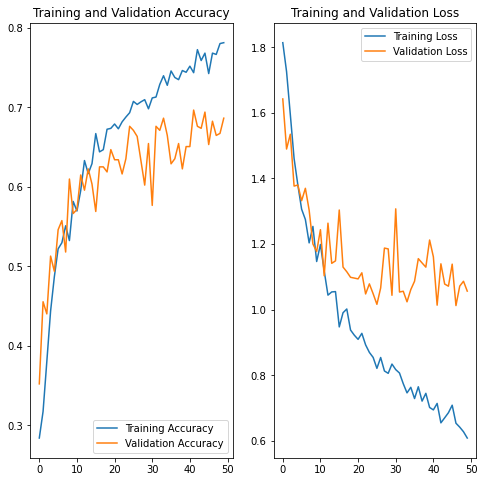

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_training_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Model Testing

The model has now been trained and has been saved to the computer (in the same folder as this notebook). The last line of the printed output above contains the accuracy for both the training data and the validation, or testing data. Pay attention to the val_accuracy value on the last line, which corresponds to the accuracy on images that the model was not trained on. This is the best measure of the estimator performance on other images.

The following function, make_prediction, takes the file path to a garbage photo as an input and outputs the classification that the model predicted. From the test folder, copy the filepath into the test_image_filepath variable in the second cell. Try out a few photos and see how the model preforms.

In [ ]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (180,180))
    img = image.img_to_array(img)

    image_array = img / 180. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = [ 'cardboard','glass', 'metal','paper','plastic', 'plasticbags', 'trash'] # possible output values
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(cardboard)|(glass)|(metal)|(paper)|(plastic)|(plasticbags)|(trash)', image_fp)[0]
    
    out = f"""Predicted debris Type: {predicted_value}
    True Debris Type: {true_value}
    Correct?: {predicted_value == true_value}"""
    
    return out

Predicted debris Type: trash
    True Debris Type: trash
    Correct?: True


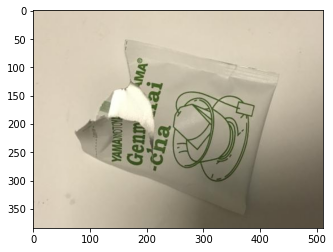

In [ ]:
test_image_filepath = test_data_directory + r'/trash/trash3.jpg'
print(make_prediction(test_image_filepath))

Predicted debris Type: plastic
    True Debris Type: plastic
    Correct?: True


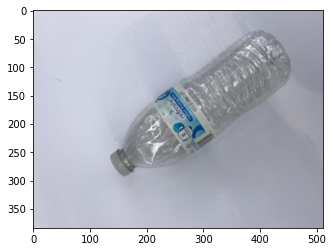

In [ ]:
test_image_filepath = test_data_directory + r'/plastic/plastic36.jpg'
print(make_prediction(test_image_filepath))

Predicted debris Type: metal
    True Debris Type: metal
    Correct?: True


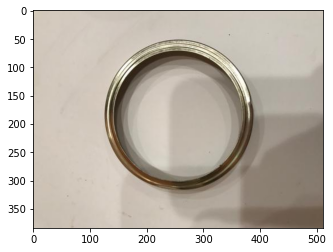

In [ ]:
test_image_filepath = test_data_directory + r'/metal/metal7.jpg'
print(make_prediction(test_image_filepath))

Predicted debris Type: cardboard
    True Debris Type: cardboard
    Correct?: True


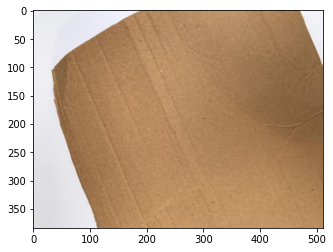

In [ ]:
test_image_filepath = test_data_directory + r'/cardboard/cardboard6.jpg'
print(make_prediction(test_image_filepath))

In [ ]:
def split_images(image_dir, save_dir):
    classification_list = [ 'cardboard','glass', 'metal','paper','plastic', 'plasticbags','trash']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            # For cropping images
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass

In [ ]:
try:
    parent = training_data_directory.replace('train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = [ 'cardboard','glass', 'metal','paper','plastic', 'plasticbags', 'trash']
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # split training images
    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('train', 'train_divided'))
    # split test images
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('test', 'test_divided'))
except FileExistsError:
    pass

In [ ]:
model_fp = os.getcwd()+'/'+'debris.h5'
print(model_fp)
model = load_model(model_fp)

//debris.h5


#Waste Generation Classification Percentages
Use the loaded model to classify a test image. The function classify_images takes an image and a model and loops through each 180x180 square. The function outputs the proportion of each trash type that was classified.

In [ ]:
def classify_images(image_fp, model):
    classes = [ 'cardboard','glass', 'metal','paper','plastic', 'plasticbags', 'trash']
    cardboard_count = 0
    glass_count = 0
    metal_count = 0
    paper_count = 0
    plastic_count = 0
    plasticbags_count = 0
    trash_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 180

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    cardboard_count += 1
                elif classification == classes[1]:
                    glass_count += 1
                elif classification == classes[2]:
                    metal_count += 1
                elif classification == classes[3]:
                    paper_count += 1
                elif classification == classes[4]:
                    plastic_count += 1
                elif classification == classes[5]:
                    plasticbags_count += 1
                elif classification == classes[6]:
                    trash_count += 1

            else:
                continue
    total_count = cardboard_count + glass_count + metal_count + paper_count + plastic_count + plasticbags_count + trash_count
    proportion_array = [cardboard_count / total_count, glass_count / total_count, metal_count / total_count, paper_count / total_count, plastic_count / total_count, plasticbags_count / total_count, trash_count / total_count]
    return proportion_array


def model_classify(cropped_img, model):
    classes = [ 'cardboard','glass', 'metal','paper','plastic', 'plasticbags', 'trash']
    image_array = cropped_img / 255
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))
    
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2, 1, 0]])

    print(f'''---
Percent cardboard: {round(out[0] * 100, 2)}%)
Percent glass: {round(out[1] * 100, 2)}%)
Percent metal: {round(out[2] * 100, 2)}%)
Percent paper: {round(out[0] * 100, 2)}%)
Percent plastic: {round(out[1] * 100, 2)}%)
Percent plastic bags: {round(out[1] * 100, 2)}%)
Percent trash: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')

In [ ]:
percentage_photo = test_data_directory + r'/plastic/plastic146.jpg'

---
Percent cardboard: 8.0%)
Percent glass: 16.0%)
Percent metal: 12.0%)
Percent paper: 8.0%)
Percent plastic: 16.0%)
Percent plastic bags: 16.0%)
Percent trash: 12.0%)
Time to Classify: 0.8996 seconds
---


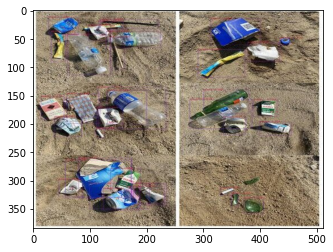

In [ ]:
classify_percentage(image_fp=percentage_photo)

In [ ]:
percentage_photo = test_data_directory + r'/plastic/plastic147.jpg'

---
Percent cardboard: 12.0%)
Percent glass: 16.0%)
Percent metal: 20.0%)
Percent paper: 12.0%)
Percent plastic: 16.0%)
Percent plastic bags: 16.0%)
Percent trash: 20.0%)
Time to Classify: 0.87131 seconds
---


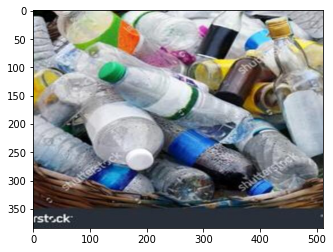

In [ ]:
classify_percentage(image_fp=percentage_photo)